<a href="https://colab.research.google.com/github/idlanqmohaimin/fyp/blob/main/test_sawi_mrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun May 30 21:34:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!ls fyp/sawi_mrcnn

datasets  mask_rcnn_object_0010.h5  requirements.txt   setup.py
logs	  mrcnn			    sawi_detection.py


In [3]:
%cd ~
!git clone https://github.com/idlanqmohaimin/fyp.git

!pwd

!cp /content/drive/MyDrive/MY214_Project_Updates/sawi_mrcnn/mask_rcnn_object_0010.h5 /root/fyp/sawi_mrcnn

/root
Cloning into 'fyp'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 71 (delta 20), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (71/71), done.
/root


In [ ]:
%cd ~/fyp/sawi_mrcnn/

!pip3 install -q PyDrive
!pip3 install -r requirements.txt
!python3 setup.py install

In [5]:
%cd ~/fyp/sawi_mrcnn/datasets

import os
from zipfile import ZipFile

fileName = 'datasets' + '.zip'
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

/root/fyp/sawi_mrcnn/datasets
Extracted zip file datasets.zip


In [2]:
%tensorflow_version 1.x

#!pip3 install h5py==2.10.0


TensorFlow 1.x selected.


In [1]:
%cd ~/fyp/sawi_mrcnn

/root/fyp/sawi_mrcnn


In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

#import custom

# Root directory of the project
ROOT_DIR = "/root/fyp/sawi_mrcnn"

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")


WEIGHTS_PATH = "/root/fyp/sawi_mrcnn/mask_rcnn_object_0010.h5"   # change it

Using TensorFlow backend.


In [4]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 1  # Background + phone,laptop and mobile

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [5]:
config = CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "/datasets/")
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [6]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "plant")


        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        
        annotations1 = json.load(open(os.path.join(dataset_dir, "sawi_growth.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
           
            polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [s['region_attributes']['sawi'] for s in a['regions']]
            print("objects:",objects)
            #name_dict = {"laptop": 1,"tab": 2,"phone": 3}
            name_dict = {"plant": 1} #,"xyz": 3}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)
    
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [7]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"
ROOT_DIR = "/root/fyp/sawi_mrcnn/datasets"

def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

# Load validation dataset
# Must call before using the dataset
CUSTOM_DIR = "/root/fyp/sawi_mrcnn/datasets"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['plant', 'plant', 'plant', 'plant']
numids [1, 1, 1, 1]
objects: ['plant', 'plant', 'plant', 'plant']
numids [1, 1, 1, 1]
objects: ['plant', 'plant', 'plant', 'plant']
numids [1, 1, 1, 1]
objects: ['plant', 'plant', 'plant', 'plant']
numids [1, 1, 1, 1]
objects: ['plant', 'plant', 'plant', 'plant']
numids [1, 1, 1, 1]
objects: ['plant', 'plant', 'plant', 'plant']
numids [1, 1, 1, 1]
objects: ['plant', 'plant', 'plant', 'plant']
numids [1, 1, 1, 1]
objects: ['plant', 'plant', 'plant', 'plant']
numids [1, 1, 1, 1]
objects: ['plant', 'plant', 'plant', 'plant']
numids [1, 1, 1, 1]
objects: ['plant', 'plant', 'plant', 'plant']
numids [1, 1, 1, 1]
objects: ['plant', 'plant', 'plant', 'plant']
numids [1, 1, 1, 1]
objects: ['plant', 'plant', 'plant', 'plant']
numids [1, 1, 1, 1]
objects: ['plant', 'plant', 'plant', 'plant']
numids [1, 1, 1, 1]
objects: ['plant', 'plant', 'plant', 'plant']
numids [1, 1, 1, 1]
objects: ['plant', 'plant', 'plant', 'plant']
numids [1, 1, 1, 1]
objects: [

In [8]:
config = CustomConfig()
#LOAD MODEL. Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [9]:
# Load COCO weights Or, load the last model you trained
weights_path = WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /root/fyp/sawi_mrcnn/mask_rcnn_object_0010.h5


In [14]:
#Now, we are ready for testing our model on any image.

#RUN DETECTION
image_id = random.choice(dataset.image_ids)
#image_id = 'D:/MaskRCNN-aar/Dataset/val/1.jfif'
print("image id is :",image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

image id is : 15
image ID: object.2021.05.10_094005_esp32-cam.jpg (15) /root/fyp/sawi_mrcnn/datasets/val/2021.05.10_094005_esp32-cam.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  243.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  120.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


gt_class_id              shape: (4,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (4, 4)                min:  165.00000  max:  810.00000  int32
gt_mask                  shape: (1024, 1024, 4)       min:    0.00000  max:    1.00000  uint8


'\npath_to_new_image = \'D:/MaskRCNN-aar/test_img.jfif\'\nimage1 = mpimg.imread(path_to_new_image)\n\n# Run object detection\nprint(len([image1]))\nresults1 = model.detect([image1], verbose=1)\n\n# Display results\nax = get_ax(1)\nr1 = results1[0]\nvisualize.display_instances(image1, r1[\'rois\'], r1[\'masks\'], r1[\'class_ids\'],\ndataset.class_names, r1[\'scores\'], ax=ax, title="Predictions1"\n'

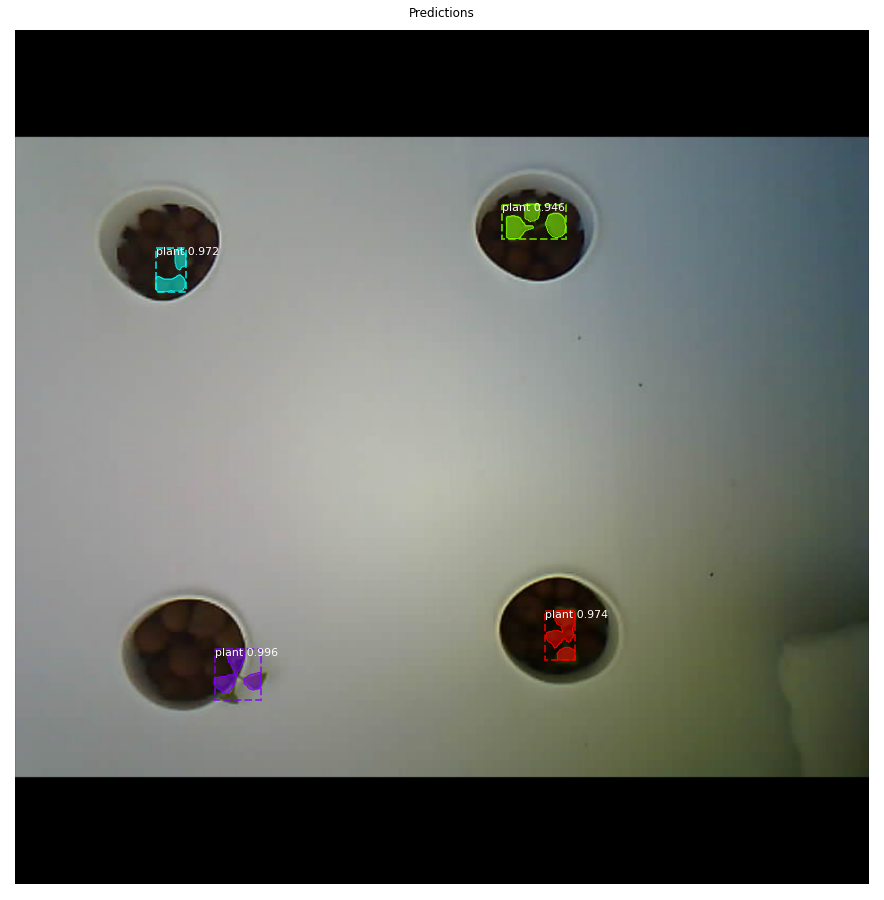

In [15]:
# Display results
x = get_ax(1)
r = results[0]
ax = plt.gca()
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], ax=ax, title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
# This is for predicting images which are not present in dataset
'''
path_to_new_image = 'D:/MaskRCNN-aar/test_img.jfif'
image1 = mpimg.imread(path_to_new_image)

# Run object detection
print(len([image1]))
results1 = model.detect([image1], verbose=1)

# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1"
'''

1
Processing 1 images
image                    shape: (600, 800, 3)         min:    0.00000  max:  240.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  121.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



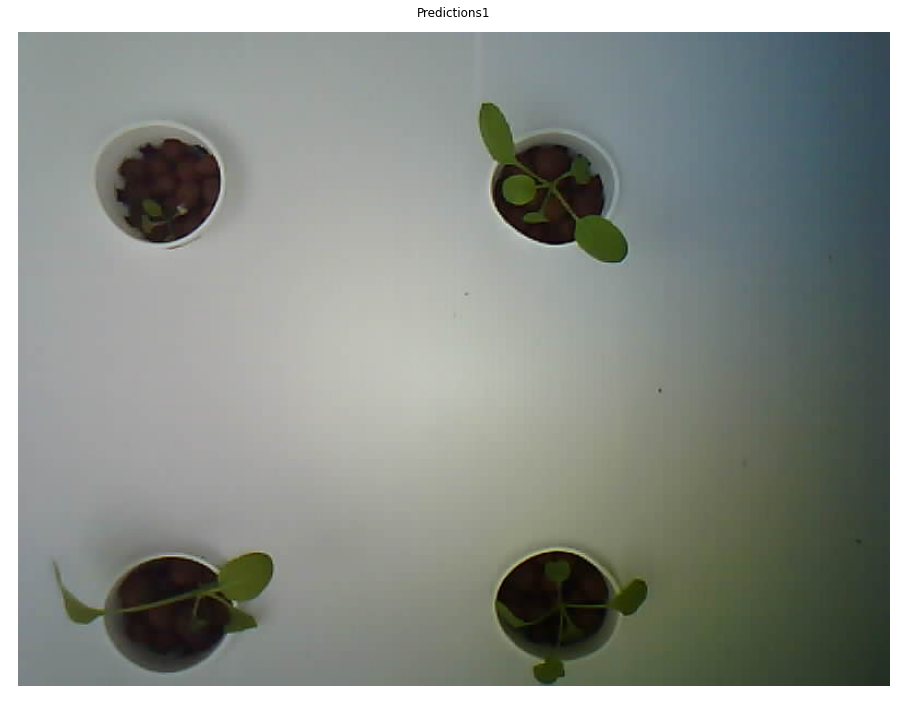

In [16]:
path_to_new_image = '/content/drive/MyDrive/MY214_Project_Updates/sawi_mrcnn/2021.05.19_08_38_51_esp32-cam.jpg'
image1 = mpimg.imread(path_to_new_image)

# Run object detection
print(len([image1]))
results1 = model.detect([image1], verbose=1)


# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1")